In [ ]:
#hide
from utils import *

# Improving training stability

Since we are so good at recognizing threes from sevens, let's move onto something harder—recognizing all 10 digits. That means we'll need to use `MNIST` instead of `MNIST_SAMPLE`:

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('testing'),Path('training')]

The data is in two folders named `training` and `testing`, so we have to tell `GrandparentSplitter` about that (it defaults to `train` and `valid`). We define a function `get_dls` to make it easy to change our batch size later:

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

Always a good idea to look at your data before you use it:

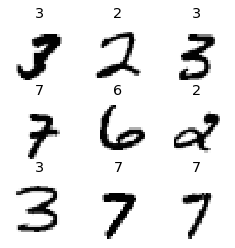

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

Now that we have our data ready, we can train a simple model on it.

## A simple baseline

In the previous chapter, we built a model based on a `conv` function like this:

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Let's start with a basic CNN as a baseline. We'll use the same as we had in the last chapter, but with one tweak: we'll use more activations.

As we discussed, we generally want to double the number of filters each time we have a stride 2 layer. So, one way to increase the number of filters throughout our network is to double the number of activations in the first layer – then every layer after that will end up twice as big as the previous version as well.

But there is a subtle problem with this. Consider the kernel which is being applied to each pixel. By default, we use a 3x3 pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four filters output. That meant that there were four values being computed from nine pixels at each location. Think about what happens if we double this output to 8 filters. Then when we apply our kernel we would be using nine pixels to calculate eight numbers. That means that it isn't really learning much at all — the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, that the number of outputs from an operation is smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5x5 pixels then there are 25 pixels being used at each kernel application — creating eight filters from this will mean the neural net will have to find some useful features.

In [ ]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

As you'll see in a moment, we're going to look inside our models while they're training in order to try to find ways to make them train better. To do this, we use the `ActivationStats` callback, which records the mean, standard deviation, and histogram of activations of every trainable layer (as we've seen, callbacks are used to add behavior to the training loop; we'll see how they work in <<chapter_callbacks>>).

In [ ]:
from fastai2.callback.hook import *

We want to train quickly, so that means training at a high learning rate. Let's see how we go at 0.06:

In [ ]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.307071,2.305865,0.113500,00:16


This didn't train at all well! Let's find out why.

One handy feature of the callbacks passed to `Learner` is that they are made available automatically, with the same name as the callback class, except in `camel_case`. So our `ActivationStats` callback can be accessed through `activation_stats`. In fact--I'm sure you remember `learn.recorder`... can you guess how that is implemented? That's right, it's a callback called `Recorder`!

`ActivationStats` includes some handy utilities for plotting the activations during training. `plot_layer_stats(idx)` plots the mean and standard deviation of the activations of layer number `idx`, along with the percent of activations near zero. Here's the first layer's plot:

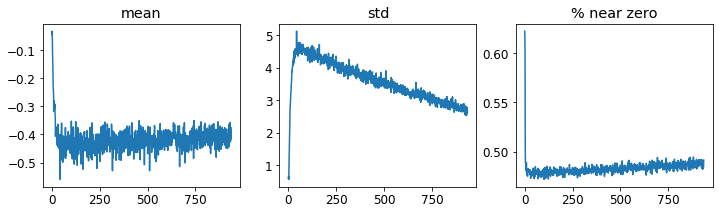

In [ ]:
learn.activation_stats.plot_layer_stats(0)

Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations during training. Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

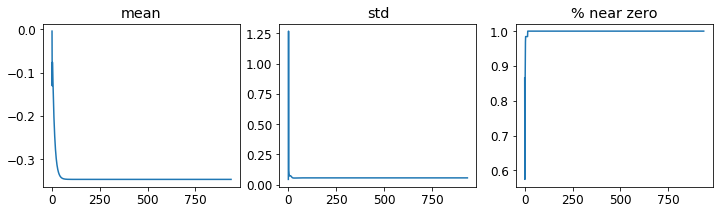

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers.

## Increase batch size

One way to make training more stable is to *increase the batch size*. Larger batches have gradients that are more accurate, since they're calculated from more data. On the downside though, a larger batch size means fewer batches per epoch, which means less opportunities for your model to update weights. Let's see if a batch size of 512 helps:

In [ ]:
dls = get_dls(512)

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.309385,2.302744,0.113500,00:08


Let's see what the penultimate layer looks like:

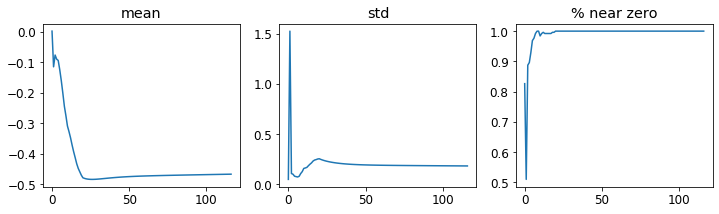

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

Again, we've got most of our activations near zero. Let's see what else we can do to improve training stability.

## 1cycle training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen above. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of training, because we'll be able to train more quickly. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

Leslie Smith (yes, the same guy that invented the learning rate finder!) developed this idea in his article [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120) by designing a schedule for learning rate separated in two phases: one were the learning rate grows from the minimum value to the maximum value (*warm-up*), and then one where it decreases back to the minimum value (*annealing*). Smith called this combination of approaches *1cycle training*.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

- By training with higher learning rates, we train faster, a phenomenon Leslie N. Smith named *super-convergence*
- By training with higher learning rates, we overfit less because we skip over the sharp local minimas to end-up in a smoother (and therefore more generalizable) part of the loss.

The second point is an interesting and subtle idea; it is based on the observation that a model that generalises well is one whose loss would not change very much if you change the input by a small amount. If a model trains at a large learning rate for quite a while, and can find a good loss when doing so, it must have found an area that also generalises well, because it is jumping around a lot from batch to batch (that is basically the definition of a high learning rate). The problem is that, as we have discussed, just jumping to a high learning rate is more likely to result in diverging losses, rather than seeing your losses improve. So we don't just jump to a high learning rate. Instead, we start at a low learning rate, where our losses do not diverge, and we allow the optimiser to gradually find smoother and smoother areas of our parameters, by gradually going to higher and higher learning rates.

Then, once we have found a nice smooth area for our parameters, we then want to find the very best part of that area, which means we have to bring out learning rates down again. This is why 1cycle training has a gradual learning rate warmup, and a gradual learning rate cooldown. Many researchers have found that in practice this approach leads to more accurate models, and trains more quickly. That is why it is the approach that is used by default for `fine_tune` in fastai.

Later in this book we'll learn all about *momentum* in SGD. Briefly, momentum is a technique where the optimizer takes a step not only in the direction of the gradients, but also continues in the direction of previous steps. Leslie Smith introduced cyclical momentums in [A disciplined approach to neural network hyper-parameters: Part 1](https://arxiv.org/pdf/1803.09820.pdf). It suggests that the momentum varies in the opposite direction of the learning rate: when we are at high learning rate, we use less momentum, and we use more again in the annealing phase.

We can use 1cycle training in fastai by calling `fit_one_cycle`:

In [ ]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.210838,0.084827,0.974300,00:08


We're finally making some progress! It's giving us a reasonable accuracy now.

We can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`. `learn.recorder` (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum:

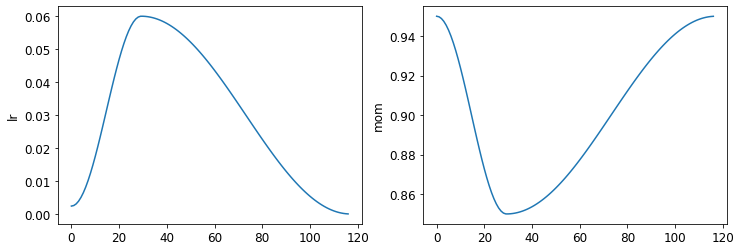

In [ ]:
learn.recorder.plot_sched()

Smith's original 1cycle paper used a linear warm-up and linear annealing. As you see above, we adapted the approach in fastai by combining it with another popular approach: cosine annealing. `fit_one_cycle` provides the following parameters you can adjust:

- `lr_max`: The highest learning rate that will be used (this can also be a list of learning rates for each layer group, or a python `slice` object containing the first and last layer group learning rates)
- `div`: How much to divide `lr_max` by to get the starting learning rate
- `div_final`:  How much to divide `lr_max` by to get the ending learning rate
- `pct_start`: What % of the batches to use for the warmup
- `moms`: A tuple `(mom1,mom2,mom3)` where mom1 is the initial momentum, mom2 is the minimum momentum, and mom3 is the final momentum.

Let's take a look at our layer stats again:

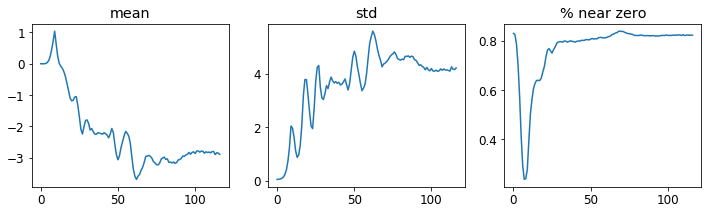

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

The % of non-zero weights is getting much better, although it's still quite high.

We can see even more about what's going on in our training using `color_dim`, passing it a layer index:

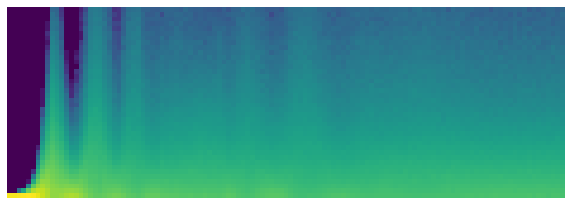

In [ ]:
learn.activation_stats.color_dim(-2)

`color_dim` was developed by fast.ai in conjunction with a student, Stefano Giomo. Stefano, who refers to the idea as the *colorful dimension*, has a [detailed explanation](https://forums.fast.ai/t/the-colorful-dimension/42908) of the history and details behind the method. The basic idea is to create a histogram of the activations of a layer, which we would hope would follow a smooth pattern such as the normal distribution shown by Stefano here:

<img src="images/colorful_dist.jpeg" id="colorful_dist" caption="Histogram in 'colorful dimension'" alt="Histogram in 'colorful dimension'" width="800">

To create `color_dim`, we take the histogram shown on the left here, and convert it into just the colored representation shown at the bottom. Then we flip it on its side, as shown on the right. We found that the distribution is clearer if we take the `log` of the histogram values. Then, Stefano describes:

> : The final plot for each layer is made by stacking the histogram of the activations from each batch along the horizontal axis. So each vertical slice in the visualisation represents the histogram of activations for a single batch. The color intensity corresponds to the height of the histogram, in other words the number of activations in each histogram bin.

This is Stefano's picture of how this all fits together:

<img src="images/colorful_summ.png" id="colorful_summ" caption="Summary of 'colorful dimension'" alt="Summary of 'colorful dimension'" width="800">

So with that in mind, let's take another look at the result for the penultimate layer:

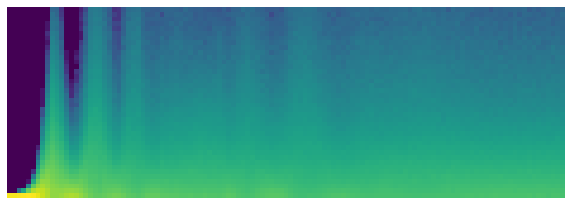

In [ ]:
learn.activation_stats.color_dim(-2)

This shows a classic picture of "bad training". We start with nearly all activations at zero--that's what we see at the far left, with nearly all the left hand side dark blue; the bright yellow at the bottom are the near-zero activations. Then over the first few batches we see the number of non-zero activations exponentially increasing. But it goes too far, and collapses! We see the dark blue return, and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again, and then it collapses again. After repeating a few times, eventually we see a spread of activations throughout the range.

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse that we see above tend to result in a lot of near-zero activations, resulting in slow training, and poor final results.

## Batch normalization

To fix this, we need to both fix the initial large percentage of near-zero activations, and then try to maintain a good distribution of activations throughout training. In the abstract, they describe just the problem that we've seen:

Sergey Ioffe and Christian Szegedy showed a solution to this problem in the 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). 

> : "Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs."

Their solution, they say is:

> : "...making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization."

The paper caused great excitement as soon as it was released, because they showed this chart, which clearly demonstrated that batch normalization could train a model that was even more accurate than the current state of the art (the *inception* architecture), around 5x faster:

<img alt="Impact of batch normalization" width="553" caption="Impact of batch normalization" id="batchnorm" src="images/att_00046.png">

The way batch normalization (often just called *batchnorm*) works is that it takes an average of the mean and standard deviations of the activations of a layer, and uses those to normalize the activations. However, this can cause problems because the network might really want some activations to be really high in order to make accurate predictions, they also add two learnable parameters (meaning they will be updated in our SGD step), usually called `gamma` and `beta`; after normalizing the activations to get some new activation vector `y`, a batchnorm layer returns `gamma*y + beta`.

That why our activations can have any mean or variance, which is independent from the mean and std of the results of the previous layer. Those statistics are learned separately, making training easier on our model. The behavior is different during training and validation: during training, we use the mean and standard deviation of the batch to normalize the data. During validation, we instead use a running mean of the statistics calculated during training.

Let's add a batchnorm layer to `conv`:

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

...and fit our model:

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.130036,0.055021,0.986400,00:10


That's a great result! Let's take a look at `color_dim`:

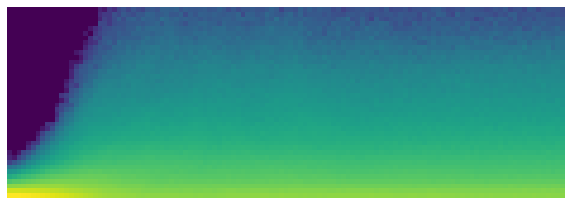

In [ ]:
learn.activation_stats.color_dim(-4)

This is just what we hope to see: a smooth development of activations, with no "crashes". Batchnorm has really delivered on its promise here! In fact, batchnorm has been so successful that we see it (or something very similar) today in nearly all modern neural networks.

An interesting observation about models containing batch normalisation layers is that they tend to generalise better than models that don't contain them. Although we haven't as yet seen a rigourous analysis of what's going on here, most researchers believe that the reason for this is that batch normalisation add some extra randomness to the training process. Each mini batch will have a somewhat different mean and standard deviation to each other mini batch. Therefore, the activations will be normalised by different values each time. In order for the model to make accurate predictions, it will have to learn to become insensitive to these variations. In general, adding additional randomisation to the training process often helps.

Since things are going so well, let's train for a few more epochs and see how it goes. In fact, let's even *increase* the learning rate, since the abstract of the batchnorm paper claimed we should be able to "train at much higher learning rates":

In [ ]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.191731,0.121738,0.960900,00:11
1,0.083739,0.055808,0.981800,00:10
2,0.053161,0.044485,0.987100,00:10
3,0.034433,0.030233,0.990200,00:10
4,0.017646,0.025407,0.991200,00:10


In [ ]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.183244,0.084025,0.975800,00:13
1,0.080774,0.067060,0.978800,00:12
2,0.050215,0.062595,0.981300,00:12
3,0.030020,0.030315,0.990700,00:12
4,0.015131,0.025148,0.992100,00:12


At this point, I think it's fair to say we know how to recognize digits! It's time to move on to something harder...

## Questionnaire

1. What method can we use to see that data in DataLoaders?
1. Why do we double the number of filters after each stride 2 conv?
1. Why do we use a larger kernel in the first conv with MNIST (with `simple_cnn`)?
1. What information does `ActivationStats` save for each layer?
1. How can we access a learner's callback after training?
1. What are the three statistics plotted by `plot_layer_stats`? What does the x-axis represent?
1. Why are activations near zero problematic?
1. What are the upsides and downsides of training with a larger batch size?
1. Why should we avoid using a high learning rate at the start of training?
1. What is 1cycle training?
1. What are the benefits of training with a high learning rate?
1. Why do we want to use a low learning rate at the end of training?
1. What is cyclical momentum?
1. What callback tracks hyperparameter values during training (along with other information)?
1. What does one column of pixels in the `color_dim` plot represent?
1. What does "bad training" look like in `color_dim`? Why?
1. What trainable parameters does a batch normalization layer contain?
1. What statistics are used to normalize in batch normalization during training? How about during validation?
1. Why do models with batch normalization layers generalize better?

### Further research

1. There are other normalization layers available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed, and how they differ from batch normalization.
1. Try moving the activation function after the batch normalization layer in `conv`. Does it make a difference? See what you can find out about what order is recommended, and why.
1. Batch normalization isn't defined for a batch size of one, since the standard deviation isn't defined for a single item. 